In [1]:
import os
import sys
import warnings
import datetime
import time
from time import strftime

import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader.data as datareader

from calendar import monthrange
import pandas_profiling as pdf


In [2]:
start_date = datetime.datetime(1961, 12, 1)
end_date = datetime.datetime(2017, 12, 31)

series_list = ["TB3MS","GS10","CPILFESL", "AWHMAN","ICSA","M08297USM548NNBR","PERMIT","USSLIND","USALOLITONOSTSAM",]


In [3]:
# get data using DataReader API
# commented out b/c scraping via Selenium as an exercise
# this is much simpler than Selenium, obv

# def get_fred_data(series, start_date, end_date):
#     retframe = datareader.DataReader(series, "fred", start_date, end_date)
#     # convert dates and set index
#     retframe['yyyymm'] = retframe.index.strftime('%Y%m')
#     retframe['yyyymm'] = [int(datestr) for datestr in retframe['yyyymm']]
#     retframe=retframe.set_index(['yyyymm'])
#     return retframe

# # 3M
# TB3MS = get_fred_data("TB3MS", start_date, end_date)
# # 10Y
# GS10  = get_fred_data("GS10", start_date, end_date)
# # manufacturing workweek
# AWHMAN = get_fred_data("AWHMAN", start_date, end_date)
# # initial claims - splice these 2
# ICSA = get_fred_data("ICSA", start_date, end_date)
# M08297USM548NNBR = get_fred_data("M08297USM548NNBR", start_date, end_date)
# # building permits
# PERMIT = get_fred_data("PERMIT", start_date, end_date)
# # leading indicators - splice these 2
# USSLIND = get_fred_data("USSLIND", start_date, end_date)
# USALOLITONOSTSAM = get_fred_data("USALOLITONOSTSAM", start_date, end_date)

In [4]:
# get data using Selenium driver

def download_fred_data(driver, series, startdate=None, enddate=None):
    FREDurl = "https://fred.stlouisfed.org/"
    driver.get(FREDurl)
    time.sleep(2)
    
    # find search form
    search_form = driver.find_element_by_id("head-search")
    search_form.send_keys(series)
    search_form.send_keys(Keys.RETURN)

    # find first result link returned
    series_link = driver.find_element_by_class_name('series-title')
    series_link.click()

    # change dates to download
    time.sleep(2)
    start_date = driver.find_element_by_id('input-cosd')
    start_date.clear()
    start_date.send_keys(startdate)

    end_date = driver.find_element_by_id('input-coed')
    end_date.clear()
    end_date.send_keys(enddate)
    
    # download
    time.sleep(2)
    download_button = driver.find_element_by_id("download-button")
    download_button.click()
    time.sleep(2)
    csv_button = driver.find_element_by_id("download-data-csv")
    csv_button.click()
    time.sleep(2)
    

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
chromedriver = "/Applications/chromedriver" # path to the chromedriver executable
os.environ["webdriver.chrome.driver"] = chromedriver

driver = webdriver.Chrome(chromedriver)

start_str = start_date.strftime('%Y-%m-%d')
end_str = end_date.strftime('%Y-%m-%d')

for s in series_list:
    download_fred_data(driver, s, start_str, end_str)



In [5]:
def convert_datestr(datestr):
    """Convert a beginning of month date string to end of month
    2018-01-01 -> 2018-01-31"""
    year_str, month_str, day_str = datestr.split('-')
    end_of_month = monthrange(int(year_str), int(month_str))[1]
    return "%s-%s-%02d" % (year_str, month_str, end_of_month)
    
    

In [6]:
# read each CSV file x.csv into a variable x
for s in series_list:
    global df
    df = pd.read_csv("%s.csv" % s)
    vars()[s] = df


In [7]:
# convert weekly to monthly
ICSA["DATE"] = pd.to_datetime(ICSA["DATE"])
ICSA.set_index("DATE", inplace=True)
ICSA = ICSA.resample("M").mean()
ICSA.head()

,ICSA
DATE,
1967-01-31,209000
1967-02-28,229000
1967-03-31,260750
1967-04-30,263000
1967-05-31,235750


In [8]:
# this is NSA data so it really has to be seasonally adjusted but not gonna

M08297USM548NNBR["DATE"] = pd.to_datetime(M08297USM548NNBR["DATE"])
M08297USM548NNBR.set_index("DATE", inplace=True)
M08297USM548NNBR = M08297USM548NNBR.resample("M").mean()
M08297USM548NNBR["M08297USM548NNBR"] *= 1000
M08297USM548NNBR.head()

,M08297USM548NNBR
DATE,
1961-12-31,393000
1962-01-31,427000
1962-02-28,318000
1962-03-31,272000
1962-04-30,265000


In [9]:
# splice ICSA before 1967
splicedate = pd.to_datetime('1967-01-01') 
ICSA_new = pd.merge(M08297USM548NNBR, ICSA, how="outer", on="DATE")
ICSA_new.loc[ICSA_new.index < splicedate, "ICSA"] = ICSA_new["M08297USM548NNBR"]
ICSA = ICSA_new[["ICSA"]]
ICSA.reset_index(inplace=True)
ICSA.head()

,DATE,ICSA
0,1961-12-31,393000.0
1,1962-01-31,427000.0
2,1962-02-28,318000.0
3,1962-03-31,272000.0
4,1962-04-30,265000.0


In [10]:
# fix date strings, turn to timestamp

df_list = [ICSA,TB3MS,GS10,AWHMAN,PERMIT,USALOLITONOSTSAM,CPILFESL]
df_names = ["ICSA","TB3MS","GS10","AWHMAN","PERMIT","USALOLITONOSTSAM","CPILFESL"]

for df_name, df in zip(df_names, df_list):
    print(df_name)
    if (type(df["DATE"].iloc[0]) == str):
        df["DATE"] = [convert_datestr(datestr) for datestr in df["DATE"]]
    df["DATE"] = pd.to_datetime(df["DATE"])
    df.set_index("DATE", inplace=True)
    print(df.shape)


    

ICSA
(673, 1)
TB3MS
(673, 1)
GS10
(673, 1)
AWHMAN
(673, 1)
PERMIT
(673, 1)
USALOLITONOSTSAM
(673, 1)
CPILFESL
(673, 1)


In [11]:
# compute spread of 10-year to 3-month
SPREAD = pd.merge(GS10, TB3MS, how="inner", on="DATE")
SPREAD = pd.DataFrame(SPREAD["GS10"]-SPREAD["TB3MS"], columns=["SPREAD"])
SPREAD.head()

,SPREAD
DATE,
1961-12-31,1.46
1962-01-31,1.36
1962-02-28,1.31
1962-03-31,1.21
1962-04-30,1.11


In [12]:
# compute change from year ago for these vars
df_list = [ICSA, AWHMAN, PERMIT, CPILFESL]
df_names = ["ICSA","AWHMAN","PERMIT", "CPILFESL"]

for df_name, df in zip(df_names, df_list):
    print(df_name)
    df[df_name] = df[df_name].pct_change(periods=12)
    df.dropna(inplace=True)
#    df.set_index("DATE")


ICSA
AWHMAN
PERMIT
CPILFESL


In [13]:
# for this model will just use 3 vars
# USALOLITONOSTSAM (growth) Index of leading economic indicators
# SPREAD (monetary policy) : 10y - 3m
# CPLFESL (inflation), YoY change in CPI ex food and enery
# Also keep 3-month to to use for Sharpe calcs downstream

ECON = pd.concat([SPREAD, USALOLITONOSTSAM, CPILFESL, TB3MS], axis=1)
ECON = ECON[["SPREAD","USALOLITONOSTSAM","CPILFESL", "TB3MS"]]
ECON.columns=["SPREAD", "LEADINGINDEX", "CPIX", "TBILL3"]
ECON.dropna(inplace=True)
ECON.tail(18)

,SPREAD,LEADINGINDEX,CPIX,TBILL3
DATE,,,,
2016-07-31,1.20,99.061934,0.021724,0.30
2016-08-31,1.26,99.079364,0.023115,0.30
2016-09-30,1.34,99.131100,0.022235,0.29
2016-10-31,1.43,99.220623,0.021738,0.33
2016-11-30,1.69,99.339085,0.021480,0.45
2016-12-31,1.98,99.465233,0.022102,0.51
2017-01-31,1.92,99.568276,0.022547,0.51
2017-02-28,1.90,99.633464,0.021975,0.52
2017-03-31,1.74,99.661940,0.019918,0.74


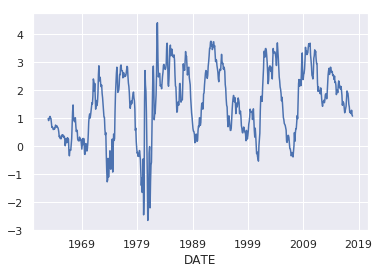

In [14]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set(rc={'patch.edgecolor': 'w', 'patch.force_edgecolor': True, 'patch.linewidth': 1})

%matplotlib inline
ECON["SPREAD"].plot("line");


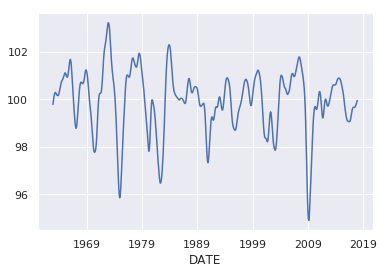

In [15]:
ECON["LEADINGINDEX"].plot("line");

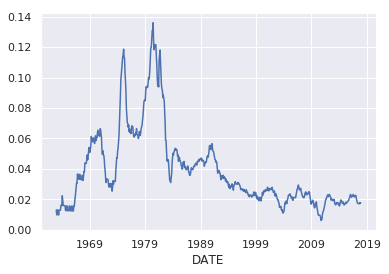

In [16]:
ECON["CPIX"].plot("line");

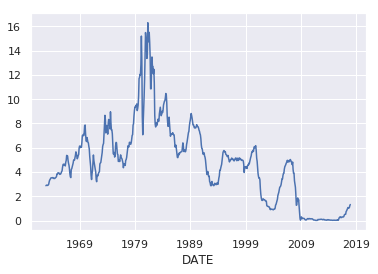

In [17]:
ECON["TBILL3"].plot("line");

In [18]:
# lead the data by 1 month
# so when you fit RET for 12/31/17, you're fitting against ECON data for 11/30
# still be an issue w/revisions etc., 
# but at least it's a point that had been released in DEC
ECON = ECON.shift(1)
ECON = ECON.dropna()
ECON.head()

,SPREAD,LEADINGINDEX,CPIX,TBILL3
DATE,,,,
1963-01-31,0.99,99.788054,0.012821,2.87
1963-02-28,0.92,99.939763,0.009615,2.91
1963-03-31,1.00,100.074720,0.012821,2.92
1963-04-30,1.04,100.184328,0.012780,2.89
1963-05-31,1.07,100.262197,0.012780,2.90


In [19]:
SP500 = pd.read_csv('SP500-MONTHLY.csv')
SP500 = SP500[['Date', 'Adj Close']]
SP500['PCTCHG'] = SP500['Adj Close'].pct_change()
SP500.head()

,Date,Adj Close,PCTCHG
0,1950-01-01,17.049999,NaN
1,1950-02-01,17.219999,0.009971
2,1950-03-01,17.290001,0.004065
3,1950-04-01,18.070000,0.045113
4,1950-05-01,18.780001,0.039292


In [20]:
SP500TR = pd.read_csv('SP500TR-MONTHLY.csv')
SP500TR = SP500TR[['Date', 'Adj Close']]
SP500TR['PCTCHG'] = SP500TR['Adj Close'].pct_change()
SP500TR.head()

,Date,Adj Close,PCTCHG
0,1989-01-01,309.209991,NaN
1,1989-02-01,301.510010,-0.024902
2,1989-03-01,308.540009,0.023316
3,1989-04-01,324.559998,0.051922
4,1989-05-01,337.690002,0.040455


In [21]:
# total return not available prior to 1988
# use pct change in raw index where not available
start_str = start_date.strftime('%Y-%m-%d')

SP500_new = pd.merge(SP500, SP500TR, how="outer", on="Date")
SP500_new["DATE"] = [convert_datestr(datestr) for datestr in SP500_new["Date"]]
SP500_new["DATE"] = pd.to_datetime(SP500_new["DATE"])
SP500_new.loc[SP500_new["PCTCHG_y"].isna(), "PCTCHG_y"] = SP500_new["PCTCHG_x"]
SP500_new = SP500_new[SP500_new["DATE"] > pd.to_datetime(start_str)]
SP500_new["SP500TR"] = SP500_new["PCTCHG_y"]
SP500_new = SP500_new[["DATE", "SP500TR"]]
SP500_new.head()

,DATE,SP500TR
143,1961-12-31,0.003225
144,1962-01-31,-0.037876
145,1962-02-28,0.016270
146,1962-03-31,-0.005860
147,1962-04-30,-0.061970


In [22]:
ECON = pd.merge(ECON, SP500_new, how="outer", on="DATE")
ECON = ECON.dropna()
ECON.head()

,DATE,SPREAD,LEADINGINDEX,CPIX,TBILL3,SP500TR
0,1963-01-31,0.99,99.788054,0.012821,2.87,0.049128
1,1963-02-28,0.92,99.939763,0.009615,2.91,-0.028852
2,1963-03-31,1.00,100.074720,0.012821,2.92,0.035464
3,1963-04-30,1.04,100.184328,0.012780,2.89,0.048520
4,1963-05-31,1.07,100.262197,0.012780,2.90,0.014327


In [23]:
%time df = pd.read_pickle('data_clean.pickle')
df.shape

CPU times: user 62.1 ms, sys: 85.2 ms, total: 147 ms
Wall time: 145 ms


(582843, 16)

In [32]:
df2 = pd.merge(df, ECON, how="inner", left_on="DATETIME", right_on="DATE")
df2.shape

(582843, 22)

In [33]:
df2.head(18)

,GVKEY,PERMNO,SYMBOL,CUSIP,COMPANY_NAME,IND_CODE,DATETIME,BM_ORIG,BM_RANK,RET,...,LAG_ME,ME_RANK,date,MEDIAN_ME,DATE,SPREAD,LEADINGINDEX,CPIX,TBILL3,SP500TR
0,1581,10401,T,00195750,A T & T CORP,32,1963-01-31,0.613024,3,0.036403,...,2.838204e+10,9,1963-01-31,68440000.0,1963-01-31,0.99,99.788054,0.012821,2.87,0.049128
1,5073,12079,GM,37044210,GENERAL MOTORS CORP,23,1963-01-31,0.408998,1,0.079570,...,1.650564e+10,9,1963-01-31,68440000.0,1963-01-31,0.99,99.788054,0.012821,2.87,0.049128
2,4503,11850,XOM,30231G10,EXXON MOBIL CORP,30,1963-01-31,0.686189,4,0.006303,...,1.288371e+10,9,1963-01-31,68440000.0,1963-01-31,0.99,99.788054,0.012821,2.87,0.049128
3,4087,11703,DD,26353410,DU PONT E I DE NEMOURS & CO,14,1963-01-31,0.336631,1,0.026096,...,1.101269e+10,9,1963-01-31,68440000.0,1963-01-31,0.99,99.788054,0.012821,2.87,0.049128
4,6066,12490,IBM,45920010,INTERNATIONAL BUSINESS MACHS CO,34,1963-01-31,0.126757,0,0.086538,...,1.079442e+10,9,1963-01-31,68440000.0,1963-01-31,0.99,99.788054,0.012821,2.87,0.049128
5,10482,14736,TX,88169410,TEXACO INC,30,1963-01-31,0.502796,2,0.005253,...,7.881081e+09,9,1963-01-31,68440000.0,1963-01-31,0.99,99.788054,0.012821,2.87,0.049128
6,5047,12060,GE,36960410,GENERAL ELECTRIC CO,21,1963-01-31,0.303114,0,0.019544,...,6.869355e+09,9,1963-01-31,68440000.0,1963-01-31,0.99,99.788054,0.012821,2.87,0.049128
7,9563,14322,S,81238710,SEARS ROEBUCK & CO,42,1963-01-31,0.365588,1,0.008117,...,5.829901e+09,9,1963-01-31,68440000.0,1963-01-31,0.99,99.788054,0.012821,2.87,0.049128
8,2991,14541,CVX,16676410,CHEVRON CORP NEW,30,1963-01-31,0.658685,4,0.031746,...,4.391415e+09,9,1963-01-31,68440000.0,1963-01-31,0.99,99.788054,0.012821,2.87,0.049128
9,4194,11754,EK,27746110,EASTMAN KODAK CO,9,1963-01-31,0.223031,0,0.047072,...,4.178840e+09,9,1963-01-31,68440000.0,1963-01-31,0.99,99.788054,0.012821,2.87,0.049128


In [34]:
df2=df2[["DATETIME", "SYMBOL", "GVKEY", "PERMNO", "IND_CODE", "BM_ORIG", "CUM_RETURN", "SPREAD", "LEADINGINDEX", "CPIX", "TBILL3", "RET", "SP500TR"]]
df2.head()

,DATETIME,SYMBOL,GVKEY,PERMNO,IND_CODE,BM_ORIG,CUM_RETURN,SPREAD,LEADINGINDEX,CPIX,TBILL3,RET,SP500TR
0,1963-01-31,T,1581,10401,32,0.613024,-0.131919,0.99,99.788054,0.012821,2.87,0.036403,0.049128
1,1963-01-31,GM,5073,12079,23,0.408998,0.030786,0.99,99.788054,0.012821,2.87,0.079570,0.049128
2,1963-01-31,XOM,4503,11850,30,0.686189,0.163202,0.99,99.788054,0.012821,2.87,0.006303,0.049128
3,1963-01-31,DD,4087,11703,14,0.336631,0.115541,0.99,99.788054,0.012821,2.87,0.026096,0.049128
4,1963-01-31,IBM,6066,12490,34,0.126757,-0.306857,0.99,99.788054,0.012821,2.87,0.086538,0.049128


In [35]:
df3=df2[['DATETIME', 'GVKEY', 'PERMNO', 'SYMBOL', 'IND_CODE',
         'BM_ORIG', 'CUM_RETURN', 'SPREAD', 'LEADINGINDEX', 'CPIX', 'TBILL3', 'RET', "SP500TR"]]
df3.columns = ["DATETIME","GVKEY","PERMNO","SYMBOL","INDUSTRY",
               "VALUE","MOMENTUM","MONETARYPOLICY","GROWTH","INFLATION", "RFRATE", "RET","SP500TR"]
df3.to_csv("df3.csv")

In [36]:
df3.head()

,DATETIME,GVKEY,PERMNO,SYMBOL,INDUSTRY,VALUE,MOMENTUM,MONETARYPOLICY,GROWTH,INFLATION,RFRATE,RET,SP500TR
0,1963-01-31,1581,10401,T,32,0.613024,-0.131919,0.99,99.788054,0.012821,2.87,0.036403,0.049128
1,1963-01-31,5073,12079,GM,23,0.408998,0.030786,0.99,99.788054,0.012821,2.87,0.079570,0.049128
2,1963-01-31,4503,11850,XOM,30,0.686189,0.163202,0.99,99.788054,0.012821,2.87,0.006303,0.049128
3,1963-01-31,4087,11703,DD,14,0.336631,0.115541,0.99,99.788054,0.012821,2.87,0.026096,0.049128
4,1963-01-31,6066,12490,IBM,34,0.126757,-0.306857,0.99,99.788054,0.012821,2.87,0.086538,0.049128


In [37]:
%time df3.to_pickle('data_econ.pickle')


CPU times: user 58.5 ms, sys: 124 ms, total: 183 ms
Wall time: 418 ms
